# Testing DEMV on Park Datset

- Positive Label: `score_cut=0`
- Protected group: males with more than 65 years (`age = 1 && sex = 0`)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

from fairlearn.reductions import ExponentiatedGradient, BoundedGroupLoss, ZeroOneLoss, GridSearch

from utils import *
from demv import DEMV

sns.set_style('whitegrid')
%load_ext autoreload
%autoreload 2

In [2]:
def prepare_data():
  data = pd.read_csv('data2/park.csv')
  data.drop(['subject#', 'a', 'y', 'yhat', 'motor_UPDRS', 'total_UPDRS', 'test_time'], axis=1, inplace=True)
  data.loc[data['age']<65, 'age'] = 0
  data.loc[data['age']>=65, 'age'] = 1
  data['score_cut'].replace({
    'Mild': 0,
    'Moderate': 1,
    'Severe': 2
  }, inplace=True)
  changed_labels = data[(data['age']==1)&(data['sex']==1)&(data['score_cut']==1)].sample(n=200).index
  data.loc[changed_labels, 'score_cut'] = 0
  return data

In [3]:
data = prepare_data()
data

,age,sex,Jitter(%),Jitter(Abs),Jitter:RAP,Jitter:PPQ5,Jitter:DDP,Shimmer,Shimmer(dB),Shimmer:APQ3,Shimmer:APQ5,Shimmer:APQ11,Shimmer:DDA,NHR,HNR,RPDE,DFA,PPE,score_cut
0,1,0,0.00662,0.000034,0.00401,0.00317,0.01204,0.02565,0.230,0.01438,0.01309,0.01662,0.04314,0.014290,21.640,0.41888,0.54842,0.16006,1
1,1,0,0.00300,0.000017,0.00132,0.00150,0.00395,0.02024,0.179,0.00994,0.01072,0.01689,0.02982,0.011112,27.183,0.43493,0.56477,0.10810,1
2,1,0,0.00481,0.000025,0.00205,0.00208,0.00616,0.01675,0.181,0.00734,0.00844,0.01458,0.02202,0.020220,23.047,0.46222,0.54405,0.21014,1
3,1,0,0.00528,0.000027,0.00191,0.00264,0.00573,0.02309,0.327,0.01106,0.01265,0.01963,0.03317,0.027837,24.445,0.48730,0.57794,0.33277,1
4,1,0,0.00335,0.000020,0.00093,0.00130,0.00278,0.01703,0.176,0.00679,0.00929,0.01819,0.02036,0.011625,26.126,0.47188,0.56122,0.19361,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5870,0,0,0.00406,0.000031,0.00167,0.00168,0.00500,0.01896,0.160,0.00973,0.01133,0.01549,0.02920,0.025137,22.369,0.64215,0.55314,0.21367,1
5871,0,0,0.00297,0.000025,0.00119,0.00147,0.00358,0.02315,0.215,0.01052,0.01277,0.01904,0.03157,0.011927,22.886,0.52598,0.56518,0.12621,1
5872,0,0,0.00349,0.000025,0.00152,0.00187,0.00456,0.02499,0.244,0.01371,0.01456,0.01877,0.04112,0.017701,25.065,0.47792,0.57888,0.14157,1
5873,0,0,0.00281,0.000020,0.00128,0.00151,0.00383,0.01484,0.131,0.00693,0.00870,0.01307,0.02078,0.007984,24.422,0.56865,0.56327,0.14204,1


In [4]:
label = 'score_cut'
sensitive_vars = ['age', 'sex']
protected_group = {'age': 1, 'sex': 0}
positive_label = 0

In [5]:
pipeline = Pipeline([
  ('scaler', StandardScaler()),
  ('classifier', LogisticRegression())
])

## Biased classifier

In [6]:
model, metrics = cross_val(pipeline, data, label, protected_group, sensitive_vars, positive_label)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [7]:
print_metrics(metrics)

Equalized odds:  0.219  +-  0.061
Disparate impact:  0.416  +-  0.089
Zero one loss:  0.238  +-  0.053
Accuracy score:  0.506  +-  0.023


## DEMV application

In [8]:
demv = DEMV(round_level=1)
demv_data = data.copy()

In [9]:
model, demv_metrics = cross_val(pipeline, demv_data, label, protected_group, sensitive_vars, positive_label, debiaser=demv)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

In [10]:
print_metrics(demv_metrics)

Equalized odds:  0.083  +-  0.04
Disparate impact:  0.78  +-  0.131
Zero one loss:  0.225  +-  0.044
Accuracy score:  0.492  +-  0.02


## DEMV Evaluation

In [11]:
demv.get_iters()

179

In [12]:
180/34

5.294117647058823

In [13]:
metrics = eval_demv(34, 180, data.copy(), pipeline, label, protected_group, sensitive_vars, positive_label=positive_label)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

##  Blackbox Postprocessing

In [14]:
model, blackboxmetrics, pred = cross_val2(pipeline, data, label, protected_group, sensitive_vars, positive_label)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3243  0.6230
1  0.5000  0.5921
2  0.0365  0.0000

1
      fpr     tpr
0  0.1415  0.4095
1  0.6596  0.7569
2  0.0804  0.1077


And loss is 0.5289


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3243  0.6230
1  0.5000  0.5921
2  0.0365  0.0000

1
      fpr     tpr
0  0.1471  0.3412
1  0.7188  0.7576
2  0.0720  0.0654


And loss is 0.5388

[0.14232339 0.16115818 0.69651843]
[0.08717801 0.14531313 0.76750886]
[0.0456933 0.1344788 0.8198279]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3056  0.6102
1  0.5106  0.6164
2  0.0379  0.0000

1
      fpr     tpr
0  0.1369  0.4343
1  0.6321  0.7396
2  0.0858  0.1383


And loss is 0.5047

[0.12968848 0.50986968 0.36044184]
[0.07570097 0.44743541 0.47686362]
[0.04250901 0.41369618 0.54379481]
[0.12968848 0.54116819 0.32914334]
[0.07168682 0.44743541 0.48087777]
[0.05282215 0.40338305 0.54379481]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3168  0.6429
1

/Users/andreadangelo/Desktop/fairness/balancers.py:634: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_pred_vecs = np.array([tools.p_vec(y_[ids]) for ids in group_ids])


[0.21092096 0.36448644 0.42459259]
[0.15622053 0.37930854 0.46447093]
[0.02884848 0.41268636 0.55846516]
[0.21092096 0.42143483 0.36764421]
[0.12723125 0.37930854 0.4934602 ]
[0.10214065 0.33939419 0.55846516]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.4023  0.6667
1  0.3684  0.5588
2  0.0400  0.0000

1
      fpr     tpr
0  0.1566  0.4095
1  0.6457  0.7362
2  0.0821  0.1102


And loss is 0.5245

[0.38764013 0.1275102  0.48484966]
[0.23942479 0.10535222 0.65522299]
[0.21422218 0.10334144 0.68243638]
[0.38764013 0.14826012 0.46409974]
[0.24404468 0.10535222 0.6506031 ]
[0.21993605 0.09762757 0.68243638]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3162  0.5645
1  0.4894  0.5765
2  0.0816  0.0000

1
      fpr     tpr
0  0.1267  0.4771
1  0.5596  0.7435
2  0.1167  0.1835


And loss is 0.4932


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3162  0.5645
1  0.4894  0.5765
2  0.0816  0.0000

1
      fpr     tpr
0  0.1344  0.4330
1  0.5838  0.7333
2  0.1221  0.1477


And loss is 0.5085

[0.14626628 0.44526214 0.40847159]
[0.08230244 0.32771826 0.58997929]
[0.08096884 0.34830885 0.57072231]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3010  0.5593
1  0.4945  0.5915
2  0.0846  0.0000

1
      fpr     tpr
0  0.1308  0.4860
1  0.5238  0.7247
2  0.1228  0.2195


And loss is 0.4820

[0.19020448 0.28758111 0.52221441]
[0.10058188 0.44533984 0.45407828]
[0.10626955 0.38512118 0.50860927]
[0.19020448 0.26992053 0.53987499]
[0.10264425 0.44533984 0.45201591]
[0.10170785 0.38968288 0.50860927]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3246  0.583

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2667  0.6447
1  0.4741  0.6875
2  0.0321  0.0000

1
      fpr     tpr
0  0.1268  0.4815
1  0.5797  0.7946
2  0.0614  0.1919


And loss is 0.4524


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2667  0.6447
1  0.4741  0.6875
2  0.0321  0.0000

1
      fpr     tpr
0  0.1333  0.4194
1  0.6307  0.7962
2  0.0600  0.1325


And loss is 0.4726

[0.03322975 0.10443544 0.86233481]
[0.01481776 0.14380166 0.84138058]
[0.01159651 0.1319132  0.8564903 ]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2389  0.6338
1  0.4865  0.7260
2  0.0347  0.0000

1
      fpr     tpr
0  0.1286  0.5000
1  0.5291  0.7803
2  0.0650  0.2647


And loss is 0.4272

[0.40917837 0.40377972 0.18704192]
[0.1591872  0.72307616 0.11773664]
[0.14525832 0.73887519 0.11586649]
[0.40917837 0.42132083 0.1695008 ]
[0.13559187 0.72307616 0.14133197]
[0.20174195 0.68239156 0.11586649]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2883  0.695

/Users/andreadangelo/Desktop/fairness/balancers.py:634: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_pred_vecs = np.array([tools.p_vec(y_[ids]) for ids in group_ids])


[0.71872977 0.17414795 0.10712228]
[0.66153442 0.13385637 0.20460921]
[0.61565289 0.06935661 0.3149905 ]
[0.71872977 0.17191134 0.10935889]
[0.68770851 0.13385637 0.17843512]
[0.57095478 0.11405473 0.3149905 ]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3596  0.6761
1  0.3478  0.6324
2  0.0360  0.0000

1
      fpr     tpr
0  0.1374  0.4815
1  0.5756  0.7697
2  0.0659  0.1959


And loss is 0.4547

[0.03515032 0.18984538 0.7750043 ]
[0.01758593 0.26359512 0.71881895]
[0.0222828  0.22174506 0.75597214]
[0.03515032 0.17123305 0.79361663]
[0.01906063 0.26359512 0.71734426]
[0.01807085 0.22595701 0.75597214]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3596  0.6176
1  0.4792  0.4754
2  0.0620  0.0000

1
      fpr     tpr
0  0.1331  0.3821
1  0.6653  0.8051
2  0.0472  0.1239


And loss is 0.5085


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3596  0.6176
1  0.4792  0.4754
2  0.0620  0.0000

1
      fpr     tpr
0  0.1476  0.3069
1  0.7143  0.7955
2  0.0469  0.0842


And loss is 0.5274

[0.1312279  0.82727623 0.04149587]
[0.11347122 0.83353806 0.05299073]
[0.09827827 0.8175112  0.08421054]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3596  0.6176
1  0.4792  0.4754
2  0.0620  0.0000

1
      fpr     tpr
0  0.1451  0.4017
1  0.6198  0.7944
2  0.0471  0.1600


And loss is 0.4839

[0.73827902 0.17066234 0.09105864]
[0.68304659 0.19764785 0.11930556]
[0.69161379 0.11420791 0.1941783 ]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3171  0.6061
1  0.4894  0.5185
2  0.0667  0.0000

1
      fpr     tpr
0  0.1303  0.4330
1  0.6476  0.8070
2  0.0522 

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3043  0.5400
1  0.5385  0.5979
2  0.0816  0.0000

1
      fpr     tpr
0  0.1103  0.4182
1  0.6071  0.8068
2  0.0804  0.1842


And loss is 0.5000


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3043  0.5400
1  0.5385  0.5979
2  0.0816  0.0000

1
      fpr     tpr
0  0.1181  0.3448
1  0.6667  0.8038
2  0.0735  0.1458


And loss is 0.5161

[0.39353473 0.29071849 0.31574678]
[0.24041831 0.38893679 0.3706449 ]
[0.1777483  0.40056052 0.42169118]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2857  0.5306
1  0.5444  0.6196
2  0.0851  0.0000

1
      fpr     tpr
0  0.1079  0.4245
1  0.5851  0.7987
2  0.0792  0.2195


And loss is 0.4839

[0.30688798 0.46719308 0.22591894]
[0.17602438 0.69195065 0.13202497]
[0.14106483 0.75158034 0.10735483]
[0.30688798 0.47864753 0.21446449]
[0.17660102 0.69195065 0.13144832]
[0.14323237 0.7494128  0.10735483]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2880  0.565

/Users/andreadangelo/Desktop/fairness/balancers.py:634: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_pred_vecs = np.array([tools.p_vec(y_[ids]) for ids in group_ids])



Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2897  0.5400
1  0.5769  0.5316
2  0.0930  0.0000

1
      fpr     tpr
0  0.1179  0.4182
1  0.6066  0.8457
2  0.0515  0.1683


And loss is 0.4925

[0.41262726 0.20233186 0.38504088]
[0.29017389 0.29880232 0.4110238 ]
[0.02729016 0.54196033 0.43074951]
[0.41262726 0.29112594 0.2962468 ]
[0.22914805 0.29880232 0.47204963]
[0.20892526 0.36032523 0.43074951]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3694  0.5745
1  0.4085  0.5632
2  0.0896  0.0000

1
      fpr     tpr
0  0.1183  0.4182
1  0.5885  0.7914
2  0.0842  0.2020


And loss is 0.4887

[0.5884114 0.2085165 0.2030721]
[0.36686747 0.27476084 0.35837168]
[0.41666667 0.21216266 0.37117067]
[0.5884114  0.17786614 0.23372245]
[0.37397851 0.27476084 0.35126064]
[0.38365492 0.24517441 0.37117067]


/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3507  0.6034
1  0.5000  0.5784
2  0.0375  0.0000

1
      fpr     tpr
0  0.1655  0.4505
1  0.5665  0.7812
2  0.0561  0.1739


And loss is 0.4719


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3507  0.6034
1  0.5000  0.5784
2  0.0375  0.0000

1
      fpr     tpr
0  0.1841  0.4536
1  0.5688  0.7784
2  0.0403  0.1429


And loss is 0.4621

[0.74737486 0.10048458 0.15214056]
[0.63724205 0.13075038 0.23200757]
[0.62515074 0.08656018 0.28828907]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3590  0.5965
1  0.5056  0.5529
2  0.0423  0.0000

1
      fpr     tpr
0  0.1680  0.4808
1  0.5464  0.7544
2  0.0618  0.2025


And loss is 0.4773

[0.4126565  0.32763469 0.25970881]
[0.26858369 0.36787615 0.36354015]
[0.19457057 0.33695931 0.46847012]
[0.4126565  0.34317954 0.24416396]
[0.2630079  0.36787615 0.36911594]
[0.21659298 0.3149369  0.46847012]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3566  0.648

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2941  0.6026
1  0.4615  0.6375
2  0.0570  0.0256

1
      fpr     tpr
0  0.1193  0.3619
1  0.7091  0.8059
2  0.0473  0.1043


And loss is 0.5128


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2941  0.6026
1  0.4615  0.6375
2  0.0570  0.0256

1
      fpr     tpr
0  0.1317  0.2727
1  0.7654  0.8026
2  0.0458  0.0549


And loss is 0.5265

[0.09724984 0.16527425 0.73747591]
[0.06968092 0.10612914 0.82418995]
[0.05212569 0.08728444 0.86058987]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2966  0.6053
1  0.4609  0.6329
2  0.0581  0.0256

1
      fpr     tpr
0  0.1345  0.3854
1  0.6809  0.7740
2  0.0537  0.1196


And loss is 0.5114

[0.14600156 0.2995352  0.55446324]
[0.0702286  0.20104225 0.72872915]
[0.07422153 0.15784621 0.76793226]
[0.14600156 0.32745274 0.5265457 ]
[0.07891657 0.20104225 0.72004118]
[0.05985516 0.17221258 0.76793226]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2931  0.596

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2727  0.6129
1  0.5306  0.6118
2  0.0476  0.0278

1
      fpr     tpr
0  0.1084  0.4746
1  0.5773  0.8152
2  0.0728  0.1765


And loss is 0.4634


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2727  0.6129
1  0.5306  0.6118
2  0.0476  0.0278

1
      fpr     tpr
0  0.1165  0.4271
1  0.6077  0.8171
2  0.0731  0.1412


And loss is 0.4735

[0.82932347 0.10317642 0.06750011]
[0.77398578 0.1096397  0.11637452]
[0.77491795 0.06655907 0.15852298]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2661  0.6207
1  0.5319  0.6027
2  0.0534  0.0278

1
      fpr     tpr
0  0.1107  0.4786
1  0.5510  0.7939
2  0.0780  0.2152


And loss is 0.4602

[0.66404775 0.22538113 0.11057112]
[0.63711947 0.16960827 0.19327226]
[0.66229223 0.07049423 0.26721354]
[0.66404775 0.17817784 0.15777441]
[0.67452795 0.16960827 0.15586378]
[0.58466633 0.14812014 0.26721354]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2920  0.644

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2869  0.7037
1  0.4812  0.6000
2  0.0331  0.0000

1
      fpr     tpr
0  0.1333  0.3596
1  0.6330  0.7952
2  0.0857  0.1250


And loss is 0.5145


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2869  0.7037
1  0.4812  0.6000
2  0.0331  0.0000

1
      fpr     tpr
0  0.1422  0.3226
1  0.6796  0.7917
2  0.0717  0.0909


And loss is 0.5246

[0.06283364 0.21997498 0.71719138]
[0.0335613  0.28057183 0.68586687]
[0.01982477 0.27334075 0.70683448]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2661  0.7051
1  0.4846  0.6140
2  0.0370  0.0000

1
      fpr     tpr
0  0.1330  0.3796
1  0.5924  0.7834
2  0.0906  0.1711


And loss is 0.4943

[0.39638843 0.20412461 0.39948697]
[0.25809228 0.38806251 0.35384521]
[0.21476772 0.42738876 0.35784352]
[0.39638843 0.27059794 0.33301363]
[0.19925106 0.38806251 0.41268642]
[0.31628028 0.3258762  0.35784352]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.2869  0.712

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3259  0.7231
1  0.4444  0.5326
2  0.0764  0.0000

1
      fpr     tpr
0  0.1136  0.4797
1  0.5751  0.8117
2  0.0758  0.1636


And loss is 0.4923


Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3259  0.7231
1  0.4444  0.5326
2  0.0764  0.0000

1
      fpr     tpr
0  0.1316  0.4300
1  0.6010  0.8148
2  0.0681  0.1398


And loss is 0.5038

[0.40334345 0.14026443 0.45639212]
[0.20008596 0.18772774 0.6121863 ]
[0.14269696 0.23874534 0.6185577 ]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3178  0.7167
1  0.4563  0.5349
2  0.0822  0.0000

1
      fpr     tpr
0  0.1136  0.4958
1  0.5400  0.7914
2  0.0814  0.1975


And loss is 0.4811

[0.42298741 0.20870826 0.36830433]
[0.22596786 0.49149984 0.2825323 ]
[0.18281188 0.52204629 0.29514183]
[0.42298741 0.28052941 0.29648318]
[0.17248563 0.49149984 0.33601453]
[0.27867476 0.42618341 0.29514183]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3306  0.770

/Users/andreadangelo/Desktop/fairness/balancers.py:634: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  p_pred_vecs = np.array([tools.p_vec(y_[ids]) for ids in group_ids])



Pre-adjustment group rates are 

0
      fpr     tpr
0  0.3900  0.7231
1  0.3889  0.4267
2  0.0857  0.0000

1
      fpr     tpr
0  0.1203  0.4797
1  0.5773  0.8472
2  0.0562  0.1237


And loss is 0.4858

[0.41953586 0.21117153 0.3692926 ]
[0.25529209 0.23303171 0.5116762 ]
[0.13925033 0.32617192 0.53457775]
[0.41953586 0.25932187 0.32114227]
[0.21511714 0.23303171 0.55185115]
[0.24285577 0.22256649 0.53457775]

Pre-adjustment group rates are 

0
      fpr     tpr
0  0.4175  0.7705
1  0.3140  0.4487
2  0.0863  0.0000

1
      fpr     tpr
0  0.1198  0.4797
1  0.5644  0.8143
2  0.0722  0.1667


And loss is 0.4858

[0.61158605 0.07356045 0.3148535 ]
[0.33582181 0.13392128 0.53025691]
[0.31750425 0.13985186 0.54264388]
[0.61158605 0.07755248 0.31086147]
[0.32064776 0.13392128 0.54543096]
[0.34610056 0.11125555 0.54264388]


## Plot

In [15]:
df = prepareplots(metrics, 'park')

In [16]:
points = preparepoints(blackboxmetrics, 170)

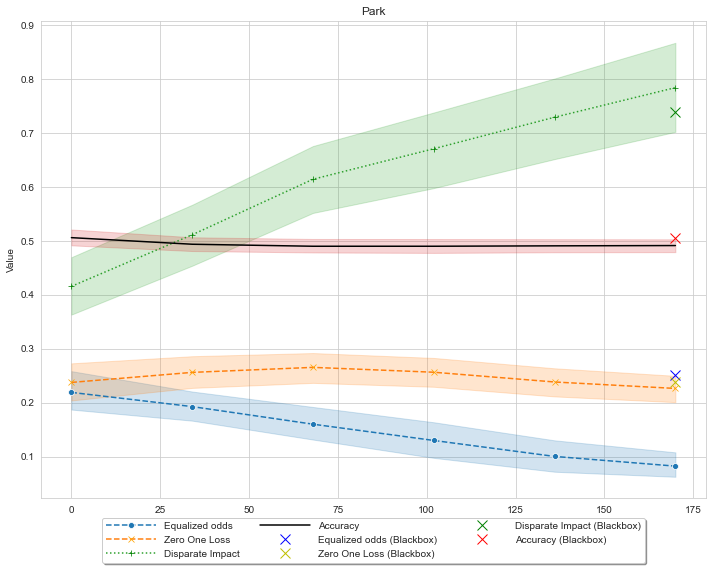

In [17]:
plot_metrics_curves(df, points, 'Park')

In [18]:
unprivpergentage(data, protected_group, 89)

Dataset size: 5875
Unprivileged group size: 2318
Percentage of unprivileged group: 39.45531914893617
Number of iterations: 89


In [19]:
save_metrics('blackbox', 'park', blackboxmetrics)